<a href="https://colab.research.google.com/github/pankaj18/time_series_forecasting/blob/master/single_layer_neural_network_for_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras 

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1:]))
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [14]:
#model
l0=tf.keras.layers.Dense(1,input_shape=[window_size])
model=tf.keras.models.Sequential([l0])


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 1190.4584
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 210.0450
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 123.9916
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 99.2143
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 86.0729
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 78.7558
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 74.6225
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 71.8829
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 69.3879
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 68.2945
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 66.7681
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 66.5888
Epoch 13/100
31/31 [=

In [17]:
print("model_weights {}".format(l0.get_weights()))

model_weights [array([[-0.01741312],
       [-0.0067623 ],
       [-0.04971535],
       [ 0.0362317 ],
       [ 0.04288156],
       [ 0.05321401],
       [-0.02612626],
       [-0.02264966],
       [-0.07096928],
       [ 0.10776083],
       [-0.04354482],
       [-0.03369498],
       [-0.02284732],
       [ 0.09759205],
       [ 0.01241094],
       [ 0.05970972],
       [-0.00558796],
       [ 0.10307116],
       [ 0.32692322],
       [ 0.4600582 ]], dtype=float32), array([0.01476659], dtype=float32)]


In [18]:
forecast=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:,0,0]


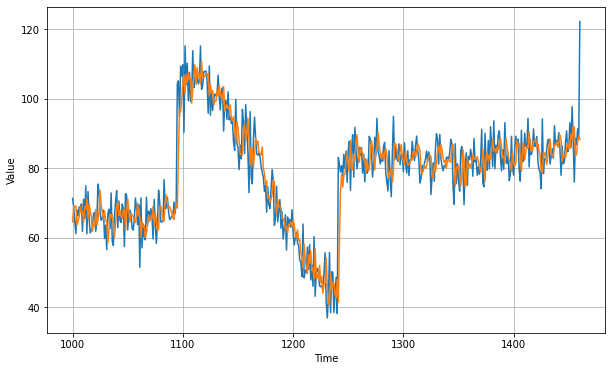

In [19]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.109645